In [188]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, ShuffleSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
import random
from collections import defaultdict
from sklearn.dummy import DummyClassifier
import sklearn.model_selection as cv

from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
font = {'size'   : 8}
plt.rc('font', **font)

#### Binary Classification

In [114]:
def get_data(path):
    df = pd.read_csv(path)
    df = df.iloc[:,2:]
    return df

def get_label(df):
    df['label'] = df['shares'].map(lambda x: 1 if x >1400 else 0)
    return df

def get_feature_target(df, train_cols):
    X = df[train_cols]
    y = df['label']
    return X, y

def feature_scaling(X):
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled

def model_eval(X_scaled, y, model):
    kf = KFold(n_splits=5, shuffle=True)
    score = []
    for train_idx, test_idx in kf.split(X_scaled):
        model.fit(X_scaled[train_idx], y.iloc[train_idx])
        y_pred = model.predict(X_scaled[test_idx])
        y_true = y.iloc[test_idx]
        score.append(f1_score(y_true, y_pred))
    return score

def model_output(train_cols):
    df = get_data('../data/train.csv')
    df = get_label(df)
    X, y = get_feature_target(df, train_cols)
    X_scaled = feature_scaling(X)
    return df, X_scaled, y
    
def print_model_score(model, train_cols):
    df, X_scaled, y = model_output(train_cols)
    score = model_eval(X_scaled, y, model)
    print("Average F1 Score:", np.average(score))
    print("F1 Score Variance:", np.var(score))

#### Feature Selection

In [115]:
df = get_data('../data/train.csv')
df = get_label(df)

In [86]:
# take all the features
train_cols = ['timedelta', 'n_tokens_title', 'n_tokens_content',
       'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
       'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'rate_positive_words',
       'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarity',
       'max_positive_polarity', 'avg_negative_polarity',
       'min_negative_polarity', 'max_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'abs_title_subjectivity',
       'abs_title_sentiment_polarity']
len(train_cols)

59

In [70]:
rf = RandomForestClassifier()
X = df[train_cols]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X,y)
rf.fit(X_train,y_train)

RandomForestClassifier()

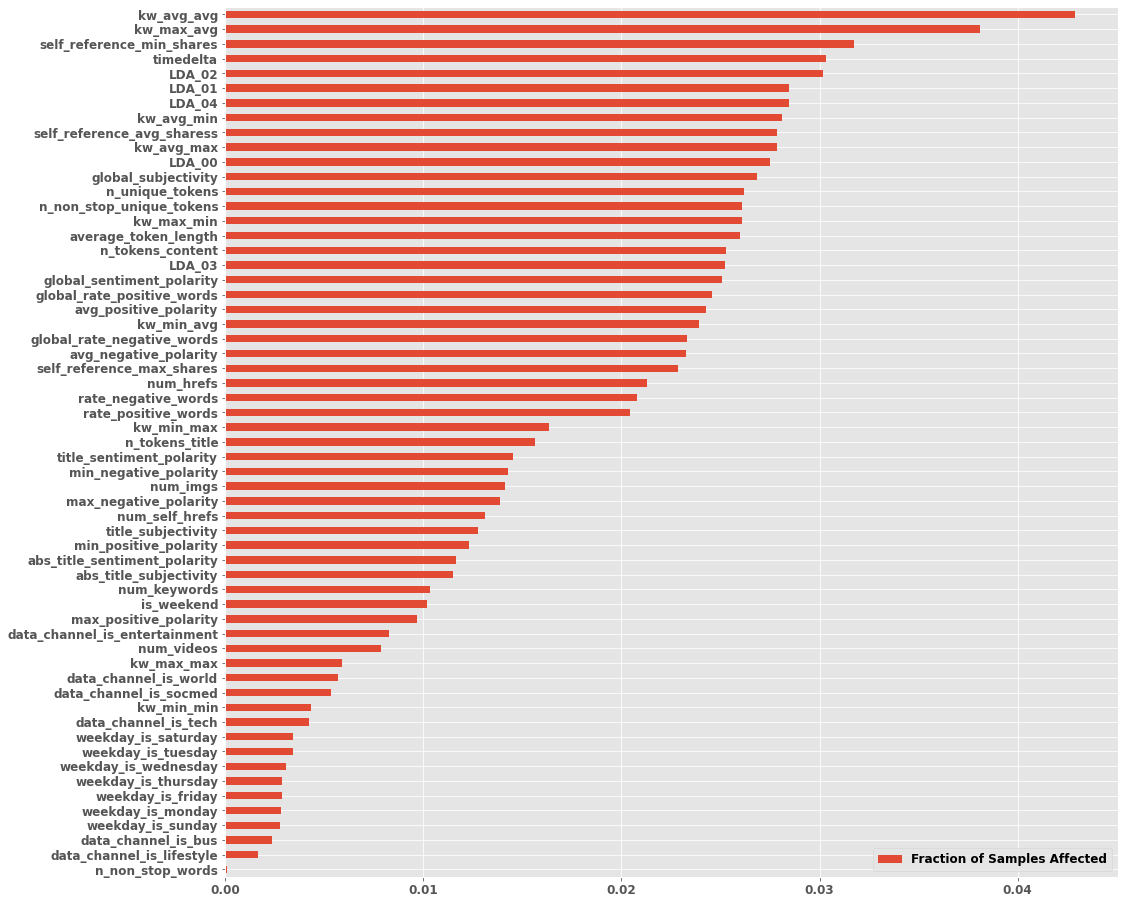

In [17]:
# Plot the feature importance
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : rf.feature_importances_},
                           index=X.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
feat_scores.plot(kind='barh', figsize = (16,16));

<AxesSubplot:>

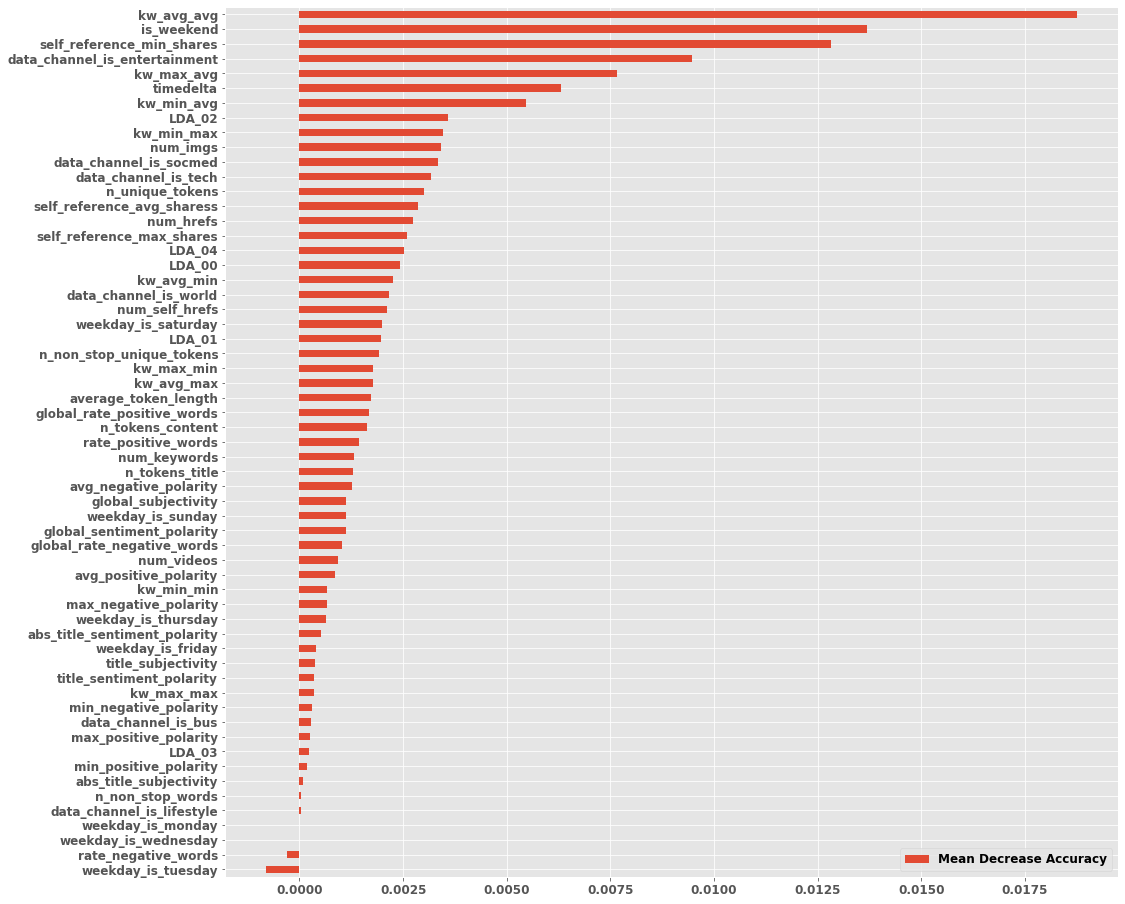

In [50]:
# Mean decrease accuracy 
scores = defaultdict(list)
rf = RandomForestClassifier()

splitter = ShuffleSplit(10, test_size=.3)

for train_idx, test_idx in splitter.split(X, y):
    X_train, X_test = X.iloc[train_idx,:], X.iloc[test_idx,:]
    y_train, y_test = y[train_idx], y[test_idx]
    rf.fit(X_train, y_train)
    acc = f1_score(y_test, rf.predict(X_test))
    for i in range(X.shape[1]):
        X_t = X_test.copy()
        np.random.shuffle(X_t.iloc[:, i].values)
        shuff_acc = f1_score(y_test, rf.predict(X_t))
        scores[train_cols[i]].append((acc-shuff_acc)/acc)

score_series = pd.DataFrame(scores).mean()
scores = pd.DataFrame({'Mean Decrease Accuracy' : score_series})
scores.sort_values(by='Mean Decrease Accuracy').plot(kind='barh', figsize = (16,16))

In [55]:
#features to remove
scores.sort_values(by='Mean Decrease Accuracy').iloc[:8,:]

,Mean Decrease Accuracy
weekday_is_tuesday,-0.000813
rate_negative_words,-0.000304
weekday_is_wednesday,-0.000019
weekday_is_monday,-0.000003
data_channel_is_lifestyle,0.000045
n_non_stop_words,0.000048
abs_title_subjectivity,0.000078
min_positive_polarity,0.000174


In [58]:
#removed features
train_cols_selected = ['timedelta', 'n_tokens_title', 'n_tokens_content',
       'n_unique_tokens','n_non_stop_unique_tokens',
       'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess',
       'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'rate_positive_words',
       'avg_positive_polarity',
       'max_positive_polarity', 'avg_negative_polarity',
       'min_negative_polarity', 'max_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity',
       'abs_title_sentiment_polarity']

#### Model Output

In [117]:
df, X_scaled, y = model_output(train_cols)

#### Baseline Model

In [77]:
base_model = DummyClassifier(strategy="stratified")
base_model.fit(X_scaled, y)
y_pred = base_model.predict(X_scaled)
f1_score(y, y_pred)

0.4919499105545617

#### RMF

In [84]:
# default hyperparameters
model = RandomForestClassifier()
print_model_score(model, train_cols)

Average F1 Score: 0.6535378705445607
F1 Score Variance: 7.219176058916033e-06


In [89]:
# Grid Search for the best hyperparameters
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size=0.3)
param_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [None, 15, 30, 59],
    'max_features': ['auto', 15, 35, 50]
}
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_test, y_test)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed: 19.2min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 15, 30, 59],
                         'max_features': ['auto', 15, 35, 50],
                         'n_estimators': [100, 200, 500, 1000]},
             verbose=2)

In [90]:
grid_search.best_params_

{'max_depth': 59, 'max_features': 'auto', 'n_estimators': 200}

In [92]:
# best hyperparameters
model = RandomForestClassifier(n_estimators=200, max_depth=59)
print_model_score(model, train_cols)

Average F1 Score: 0.6566365991634624
F1 Score Variance: 4.711547161890572e-06


#### LR

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size=0.3)
model = LogisticRegression(solver='sag')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f1_score(y_test, y_pred)

0.6338750136328936

In [119]:
# confusion matrix
pd.crosstab(y_test, y_pred, rownames=['actual'], colnames=['predicted'])

predicted,0,1
actual,,
0,3252,1589
1,1768,2906


In [120]:
model.predict_proba(X_test)

array([[0.73421375, 0.26578625],
       [0.65403383, 0.34596617],
       [0.53113326, 0.46886674],
       ...,
       [0.45868112, 0.54131888],
       [0.36948038, 0.63051962],
       [0.36116032, 0.63883968]])

In [121]:
model.classes_

array([0, 1])

In [124]:
# look at different thresholds
def predict(model, X, threshold=0.5):
    '''Return prediction of the fitted binary-classifier model model on X using
    the specifed `threshold`. NB: class 0 is the positive class'''
    return np.where(model.predict_proba(X)[:, 0] > threshold,
                    model.classes_[0],
                    model.classes_[1])

def confusion_matrix(model, X, threshold=0.5):
    cf = pd.crosstab(y_test, predict(model, X, threshold))
    #cf = cf.add(pd.DataFrame([[0,0],[0,0]], columns=['Not', 'Popular'], index=['Not', 'Popular']), fill_value=0)
    cf.index.name = 'actual'
    cf.columns.name = 'predicted'
    return cf

In [131]:
confusion_matrix(model, X_test, 0.5)

predicted,0,1
actual,,
0,3252,1589
1,1768,2906


#### Assumptions
* True positive: the article is popular and we put more ads to increase revenue
* True negative: the article is not popular
* False positive: the article is not popular and we put more ads
* False negative: the article is popular and opportunity cost occures

Let's assume a popular article will bring \\$5 in ads revenue in average, a not popular article will bring \\$-2 in ads revenue. It costs \\$3 to do improvement on not popular article to make it popular. The opportunity cost of a popular article which predicted as not popular is \\$3.

In [163]:
def currency_format(num):
    if num < 0:
        return f'-${abs(num):,.0f}'
    else:
        return f'${num:,.0f}'
    
pd.options.display.float_format = currency_format
cb_matrix = pd.DataFrame([[-2., -5.], [2., 5.]], columns=[0, 1], index=[0, 1])
cb_matrix.index.name = 'actual'
cb_matrix.columns.name = 'predicted'
cb_matrix

predicted,0,1
actual,,
0,-$2,-$5
1,$2,$5


In [164]:
confusion_matrix(model, X_test, 0.5) * cb_matrix

predicted,0,1
actual,,
0,"-$6,504","-$7,945"
1,"$3,536","$14,530"


In [165]:
# total payout
(confusion_matrix(model, X_test, 0.5) * cb_matrix).values.sum()

3617.0

In [166]:
for threshold in np.arange(0.0, 1.01, 0.05):
    print("The payout for a threshold of {:3.2f} is ${:>5.0f}".
            format(threshold,
            (confusion_matrix(model, X_test, threshold) * cb_matrix).values.sum()))

The payout for a threshold of 0.00 is $  nan
The payout for a threshold of 0.05 is $ -322
The payout for a threshold of 0.10 is $ -256
The payout for a threshold of 0.15 is $  -94
The payout for a threshold of 0.20 is $  314
The payout for a threshold of 0.25 is $  776
The payout for a threshold of 0.30 is $ 1451
The payout for a threshold of 0.35 is $ 2153
The payout for a threshold of 0.40 is $ 2822
The payout for a threshold of 0.45 is $ 3365
The payout for a threshold of 0.50 is $ 3617
The payout for a threshold of 0.55 is $ 3353
The payout for a threshold of 0.60 is $ 2951
The payout for a threshold of 0.65 is $ 2135
The payout for a threshold of 0.70 is $  980
The payout for a threshold of 0.75 is $ -136
The payout for a threshold of 0.80 is $ -763
The payout for a threshold of 0.85 is $ -832
The payout for a threshold of 0.90 is $  nan
The payout for a threshold of 0.95 is $  nan
The payout for a threshold of 1.00 is $  nan


Text(0.5, 1.0, 'Profit Curve')

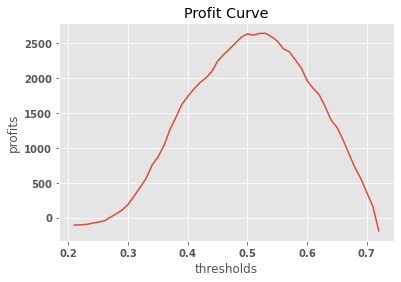

In [186]:
def calculate_payout(cb_matrix, model, X, threshold):
    return (confusion_matrix(model, X, threshold) * cb_matrix).values.sum()

thresholds = np.arange(0.0, 1.0, 0.01)
profits = []
for threshold in thresholds:
    profits.append(calculate_payout(cb_matrix, model, X_test, threshold))

fig, ax = plt.subplots()
ax.plot(thresholds, profits)
ax.set_xlabel('thresholds')
ax.set_ylabel('profits')
ax.set_title('Profit Curve')

#### Gradient Boosting

In [81]:
model = GradientBoostingClassifier()
print_model_score(model, train_cols)

F1 Score: 0.661076162208497


In [171]:
# Varying the learning rate
N_ESTIMATORS = 200
N_FOLDS = 5

learning_rates = [1, 0.5, 0.1, 0.025, 0.01]
N_LEARNING_RATES = len(learning_rates)

train_scores = np.zeros((N_FOLDS, N_LEARNING_RATES, N_ESTIMATORS))
test_scores = np.zeros((N_FOLDS, N_LEARNING_RATES, N_ESTIMATORS))

folds = cv.KFold(n_splits=N_FOLDS, shuffle=True, random_state=1)

for k, (train_idxs, test_idxs) in enumerate(folds.split(X)):
    X_train, y_train = X_scaled[train_idxs, :], y[train_idxs]
    X_test, y_test = X_scaled[test_idxs, :], y[test_idxs]

    models = [GradientBoostingClassifier(n_estimators=N_ESTIMATORS,
                                        max_depth=3, learning_rate=lr, subsample=0.5,
                                        random_state=154) 
              for lr in learning_rates]
    for model in models:
        model.fit(X_train, y_train)
    
    for i, model in enumerate(models):
        for j, y_pred in enumerate(model.staged_predict(X_train)):
            train_scores[k, i, j] = model.loss_(y_train, y_pred)
        
    for i, model in enumerate(models):
        for j, y_pred in enumerate(model.staged_predict(X_test)):
            test_scores[k, i, j] = model.loss_(y_test, y_pred)

mean_train_scores = np.mean(train_scores, axis=0)
mean_test_scores = np.mean(test_scores, axis=0)

In [176]:
np.max(mean_train_scores)

1.4043953810222731

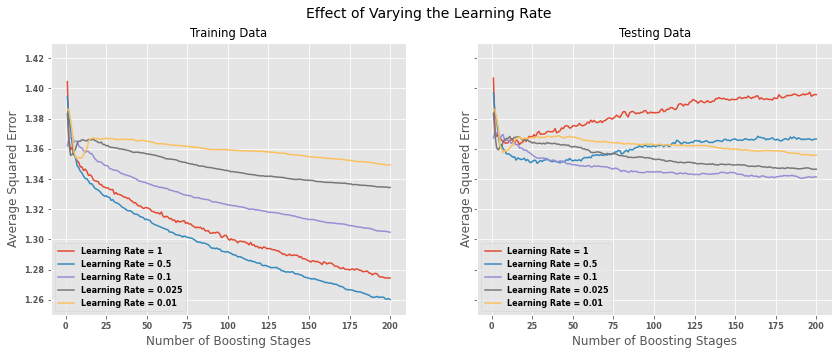

In [192]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, 
                         figsize=(14.0, 5.0))
 
for i, rate in enumerate(learning_rates):    
    ## train scores
    axes[0].plot(np.arange(N_ESTIMATORS) + 1, mean_train_scores[i, :],
                 label="Learning Rate = " + str(rate))
    ## test scores
    axes[1].plot(np.arange(N_ESTIMATORS) + 1, mean_test_scores[i, :],
                 label="Learning Rate = " + str(rate))
## common format
for ax in axes:
    ax.legend(loc = "lower left")
    ax.set_xlabel('Number of Boosting Stages', fontsize=12)
    ax.set_ylabel('Average Squared Error', fontsize=12)
## subplot titles
axes[0].set_title("Training Data")
axes[1].set_title("Testing Data")

plt.ylim([1.25, 1.43])
_ = plt.suptitle("Effect of Varying the Learning Rate", fontsize=14)
# plt.savefig('plots/varying-learning-rate-error.png', bbox_inches='tight')

In [193]:
model = GradientBoostingClassifier(n_estimators=200,
                                        max_depth=3, learning_rate=0.1, subsample=0.5,
                                        random_state=154)
print_model_score(model, train_cols)

Average F1 Score: 0.6615475992410491
F1 Score Variance: 3.441602655515651e-05


#### EDA

In [196]:
df['shares'].describe()

count    $31,715
mean      $3,409
std      $11,785
min           $1
25%         $944
50%       $1,400
75%       $2,800
max     $843,300
Name: shares, dtype: float64

<AxesSubplot:>

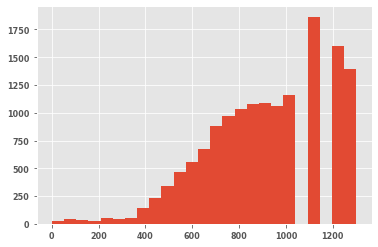

In [203]:
df[df['shares'] < 1400]['shares'].hist(bins=25)

<AxesSubplot:>

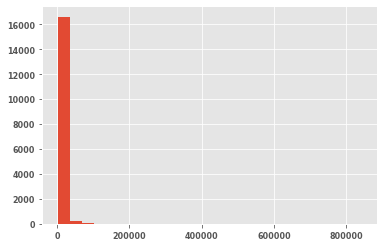

In [204]:
df[df['shares'] >= 1400]['shares'].hist(bins=25)

In [215]:
df[df['shares'] < 1100].shape

(9964, 61)

In [226]:
df1 = df[(df['shares'] >= 1100) & (df['shares'] < 2100)]

In [227]:
df2 = df[~((df['shares'] >= 1100) & (df['shares'] < 2100))]

In [217]:
df[df['shares'] >= 2100].shape

(10869, 61)

In [229]:
pd.concat([df1, df2])

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,label
4,$197,$11,$928,$0,$1,$0,$6,$6,$19,$0,...,$0,-$0,-$0,-$0,$0,$0,$0,$0,1300,0
6,$600,$11,$97,$1,$1,$1,$3,$1,$0,$0,...,$0,-$0,-$0,-$0,$1,$0,$0,$0,1500,1
8,$619,$12,$158,$1,$1,$1,$3,$2,$1,$0,...,$0,-$0,-$0,-$0,$0,-$0,$0,$0,1600,1
9,$687,$12,$502,$1,$1,$1,$13,$1,$8,$0,...,$1,-$0,-$1,-$0,$1,$0,$0,$0,1500,1
17,$96,$9,$668,$0,$1,$1,$10,$0,$2,$0,...,$1,-$0,-$1,-$0,$0,$0,$0,$0,1200,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31709,$59,$12,$527,$1,$1,$1,$2,$2,$18,$0,...,$1,-$0,-$1,-$0,$0,$1,$0,$1,1000,0
31710,$677,$9,"$1,599",$0,$1,$1,$63,$54,$1,$0,...,$1,-$0,-$1,-$0,$0,$0,$0,$0,5100,1
31711,$633,$11,$291,$1,$1,$1,$5,$1,$1,$0,...,$0,-$0,-$0,-$0,$0,$0,$0,$0,2300,1
31712,$419,$7,$327,$1,$1,$1,$12,$8,$1,$0,...,$0,-$0,-$0,-$0,$0,$0,$0,$0,689,0
